In [1]:
%matplotlib inline
import os, time, sys
import tables as tb
import matplotlib
matplotlib.rcParams["font.size"] = "14"

import matplotlib.pyplot as plt
import numpy as np
import importlib

import clicfast2023.analysis.interpreter as interpreter
importlib.reload(interpreter)

import clicfast2023.analysis.event_builder as event_builder
importlib.reload(event_builder)

import clicfast2023.analysis.fitfunctions as fitfunctions
importlib.reload(fitfunctions)

<module 'clicfast2023.analysis.fitfunctions' from '/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/analysis/fitfunctions.py'>

In [2]:
fraw = '/home/thirono/cernbox/2024-04-12/20240416_170037_injection_scan.h5'
fhit = fraw[:-7 ]+'hit.h5'
#interpreter.interpret_h5(fraw, fhit)
#event_builder.build_h5(fraw, fhit)

with tb.open_file(fhit) as f:
    ev = f.root.event_data[:]
    hit = f.root.hit_data[:]

with tb.open_file(fraw) as f:
    param=f.root.scan_parameters[:]
    raw = f.root.raw_data[:]


In [3]:
%matplotlib inline
fig, ax = plt.subplots()
comp=5
tmp = ev[ev['comp']==comp]
phase = param[ tmp['event_number']]['phase']
tdc = tmp['tdc']
toa = tmp['toa']
fit1 = fitfunctions.fit_line(phase[(phase>640) & (phase<732)], tdc[(phase>640) & (phase<732)])
fit2 = fitfunctions.fit_line(phase[(phase>608) & (phase<630)], tdc[(phase>608) & (phase<630)])
print(fit1, fit2)

ax.plot(phase-512, tdc)
#ax2.set_ylim(0,10)
x = phase
ax.plot(x-512, fitfunctions.line(x, *fit1[:2]), 'C3')

ax.set_ylim(0, 300)

plt.xlabel('Delay [1a.u=78ps]')
plt.ylabel('TDC value [1a.u=5ns-clock]')
fig.tight_layout()
plt.savefig('/home/thirono/Nextcloud-adl/FromIvan/clicfast2023_tdac/tdc.eps', format='eps', dpi=600)


(1.6693868454613878, -986.3433320304681, 0.0014137355624660023, 0.9705333281935438) (1.2554545454551147, -726.1692207808152, 0.01317804437166181, 8.15759975559263)


(306.4767400150589, -0.00908288974309525, 1.1915383712725518)


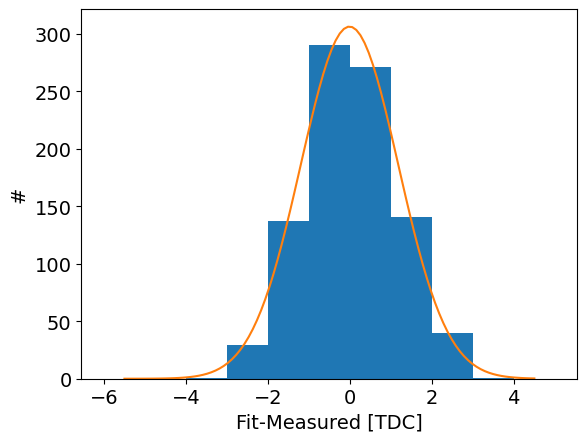

In [37]:
x = phase[(phase>640) & (phase<732)]
y = tdc[(phase>640) & (phase<732)]
diff = y-fitfunctions.line(x, *fit1[:2])
hist=plt.hist(diff, bins=np.arange(-6,6,1))
x = (hist[1][1:]+hist[1][:-1])/2
y = hist[0]
p=fitfunctions.fit_gauss(x, y)
print(p)
x =np.linspace(x[0],x[-1], 100)
plt.plot(x, fitfunctions.gauss(x, *p[:3]))
plt.xlabel('Fit-Measured [TDC]')
plt.ylabel('#')
1.1915383712725518 /1.6693868454613878 *78.125
plt.savefig('/home/thirono/Nextcloud-adl/FromIvan/clicfast2023_tdac/hist.eps', format='eps', dpi=600)

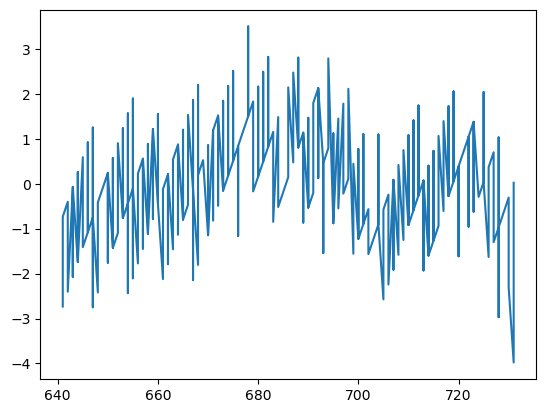

In [20]:
x = phase[(phase>640) & (phase<732)]
plt.plot(x, diff)

(20.47889472850248, -12165.874531002859, 0.0131478805544319, 9.026055918783095)


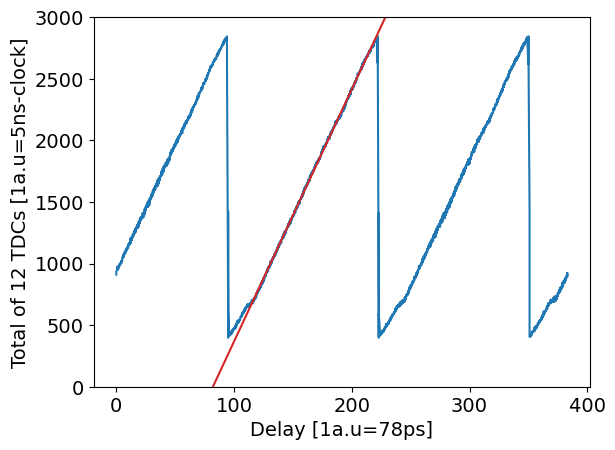

In [94]:
ev['tdc'][ev['tdc']<25] = ev['tdc'][ev['tdc']<25] +256
uni, idx, cnt = np.unique(ev['timestamp'], return_index=True, return_counts=True)

tdc= np.empty(len(uni))
for i,u in enumerate(uni):
    if cnt[i]!=12:
        print(i,u, cnt[i])
        tdc[i]=np.nan
    else:
        nofsmall = np.sum(ev['tdc'][idx[i]:idx[i]+cnt[i]] < 25)
        tdc[i]=np.sum(ev['tdc'][idx[i]:idx[i]+cnt[i]])+ nofsmall*256
        
phase = param[ev['event_number'][idx]]['phase']
plt.plot(phase-512, tdc)
fit1 = fitfunctions.fit_line(phase[(phase>640) & (phase<732)], tdc[(phase>640) & (phase<732)])
plt.plot(phase-512, fitfunctions.line(phase, *fit1[:2]), 'C3')
plt.ylim(0,3000)
plt.xlabel('Delay [1a.u=78ps]')
plt.ylabel('Total of 12 TDCs [1a.u=5ns-clock]')
fig.tight_layout()
plt.savefig('/home/thirono/Nextcloud-adl/FromIvan/clicfast2023_tdac/tdc_total.eps', format='eps', dpi=600)
print(fit1)

<ErrorbarContainer object of 3 artists>

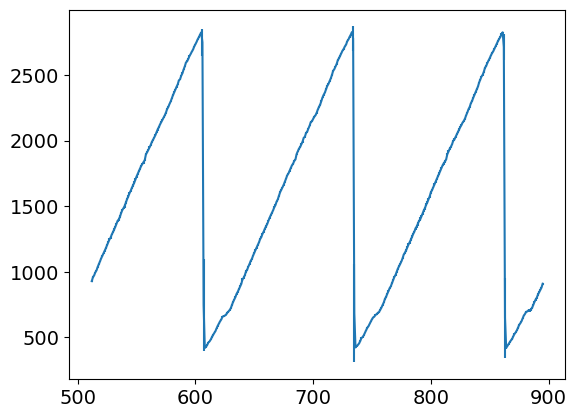

In [102]:
uni_ev, idx_ev ,cnt_ev = np.unique(ev[idx]['event_number'], return_index=True, return_counts=True)
ave_tdc=np.empty(len(uni_ev))
std_tdc=np.empty(len(uni_ev))
diff = np.empty([len(uni_ev), 10])
for i,u in enumerate(uni_ev):
    ave_tdc[i]=np.average(tdc[idx_ev[i]:idx_ev[i]+cnt_ev[i]])
    std_tdc[i]=np.std(tdc[idx_ev[i]:idx_ev[i]+cnt_ev[i]])
    diff[i, :] = tdc[idx_ev[i]:idx_ev[i]+cnt_ev[i]]-ave_tdc[i]
    
phase = param['phase'][uni_ev]
plt.errorbar(phase, ave_tdc, yerr=std_tdc)

In [115]:

cut_diff=diff[(phase>640) & (phase<732)]
hist = plt.hist(np.reshape(cut_diff, [10*len(cut_diff),]), bins=np.arange(-50,50,1));

x = (hist[1][1:]+hist[1][:-1])/2
y = hist[0]
p=fitfunctions.fit_gauss(x, y)
print(p)
x =np.linspace(x[0],x[-1], 100)
plt.plot(x, fitfunctions.gauss(x, *p[:3]))
plt.xlabel('Fit-Measured [TDC]')
plt.ylabel('#')
fig.tight_layout()
plt.savefig('/home/thirono/Nextcloud-adl/FromIvan/clicfast2023_tdac/hist_diff_from_ave.eps', format='eps', dpi=600)

(57.514482235530245, 0.36265951467163154, 6.231139051466851)


(67.30865629148721, 0.25740666534943674, 10.948505170783822)


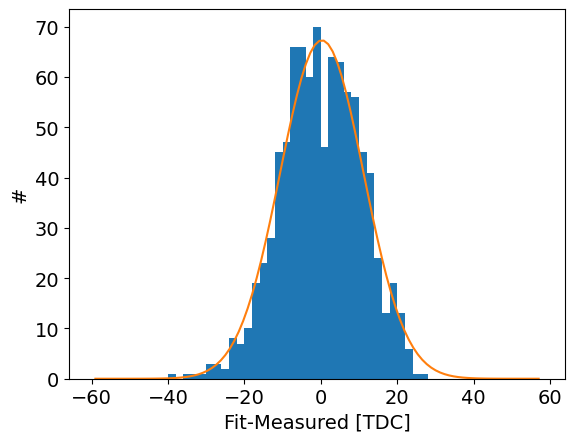

In [87]:
x = phase[(phase>640) & (phase<732)]
y = tdc[(phase>640) & (phase<732)]
diff = y-fitfunctions.line(x, *fit1[:2])
hist=plt.hist(diff, bins=np.arange(-60,60,2))
x = (hist[1][1:]+hist[1][:-1])/2
y = hist[0]
p=fitfunctions.fit_gauss(x, y)
print(p)
x =np.linspace(x[0],x[-1], 100)
plt.plot(x, fitfunctions.gauss(x, *p[:3]))
plt.xlabel('Fit-Measured [TDC]')
plt.ylabel('#')
1.1915383712725518 /1.6693868454613878 *78.125
plt.savefig('/home/thirono/Nextcloud-adl/FromIvan/clicfast2023_tdac/hist_total.eps', format='eps', dpi=600)